# I - Préliminaires - Fonctions utiles

In [1]:
%matplotlib inline
import os
os.environ["KERAS_BACKEND"] = "torch"
import torch
print("Device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")

Device: NVIDIA GeForce RTX 3060 Ti


In [2]:
import matplotlib.pyplot as plt
import itertools
import numpy as np
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Matrice de confusion',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    :param cm: (numpy matrix) confusion matrix
    :param classes: [str]
    :param normalize: (bool)
    :param title: (str)
    :param cmap: (matplotlib color map)
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    plt.figure(figsize=(8, 8))   
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Vérité Terrain')
    plt.xlabel('Prédiction')

# II - Entraînement d'un CNN pour la classification sur CIFAR10

### II.1. Chargement et Dimensionnement de la base CIFAR10

In [3]:
from keras import backend as K
print(K.backend())

torch


In [4]:
from keras.api.datasets import cifar10

In [5]:
(x_train_full, y_train_full), (x_test_full, y_test_full) = cifar10.load_data()
print("Dimension de la base d'apprentissage CIFAR10 :",x_train_full.shape)
print("Dimension des vecteurs d'étiquette de classe :",y_train_full.shape)
print("Dimension de la base de test CIFAR10 :",x_test_full.shape)

Dimension de la base d'apprentissage CIFAR10 : (50000, 32, 32, 3)
Dimension des vecteurs d'étiquette de classe : (50000, 1)
Dimension de la base de test CIFAR10 : (10000, 32, 32, 3)


In [6]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Réduction de la taille du dataset (pour accélérer l'apprentissage), et standardisation des données

In [7]:
n_training_samples = 5000
n_other_samples = 2000

def standardize(img_data):
    img_data_mean = np.mean(img_data, axis=(1,2), keepdims=True)
    img_data_std = np.std(img_data, axis=(1,2), keepdims=True)
    img_data = (img_data - img_data_mean) / img_data_std
    return img_data

train_ids = np.random.choice(len(x_train_full), size=n_training_samples, replace=False)
other_ids = np.random.choice(len(x_test_full), size=n_other_samples, replace=False)

n_valid = n_other_samples // 2
val_ids = other_ids[:n_valid]
test_ids = other_ids[n_valid:]

x_train_initial, y_train = x_train_full[train_ids], y_train_full[train_ids]
x_val_initial, y_val = x_test_full[val_ids], y_test_full[val_ids]
x_test_initial, y_test = x_test_full[test_ids], y_test_full[test_ids]

x_train = standardize(x_train_initial)
x_val = standardize(x_val_initial)
x_test = standardize(x_test_initial)

print("Dimension de notre base d'apprentissage :",x_train.shape)
print("Dimension des vecteurs d'étiquette de classe :",y_train.shape)
print("Dimension de notre base de validation :",x_val.shape)
print("Dimension de notre base de test :",x_test.shape)


Dimension de notre base d'apprentissage : (5000, 32, 32, 3)
Dimension des vecteurs d'étiquette de classe : (5000, 1)
Dimension de notre base de validation : (1000, 32, 32, 3)
Dimension de notre base de test : (1000, 32, 32, 3)


On affiche quelques images d'entraînement avec leur étiquette...

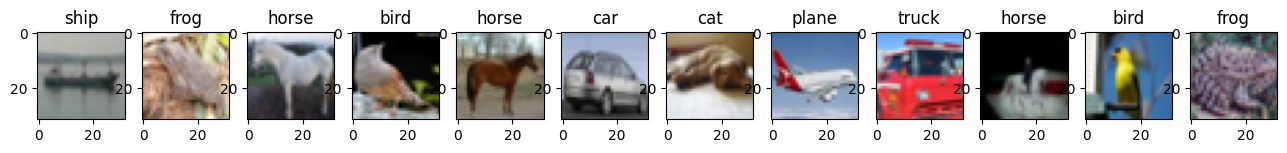

In [8]:
n_display = 12
random_ids = np.random.choice(len(x_train), n_display, replace=False)
f, axarr = plt.subplots(1,n_display,figsize=(16,16))
for k in range(n_display):
    axarr[k].imshow(x_train_initial[random_ids[k]])
    axarr[k].title.set_text(classes[y_train[random_ids[k]][0]])

In [9]:
from keras.api.utils import to_categorical
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

print("Dimension des matrices d'étiquette de classe (train) :",y_train.shape)
print("Dimension des matrices d'étiquette de classe (val) :",y_val.shape)
print("Dimension des matrices d'étiquette de classe (test) :",y_test.shape)

Dimension des matrices d'étiquette de classe (train) : (5000, 10)
Dimension des matrices d'étiquette de classe (val) : (1000, 10)
Dimension des matrices d'étiquette de classe (test) : (1000, 10)


### II.2. Definition de l'architecture du CNN

Un simple réseau convolutionnel... 

In [10]:
from keras.api.models import Sequential
from keras.api.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, Activation
from keras.api.regularizers import l2

model = Sequential()
model.add(Conv2D(filters=8, 
                kernel_size = (3, 3),
                activation = 'relu',
                padding = 'same',
                input_shape = (32, 32, 3),
                kernel_regularizer = l2(0.00)))
model.add(Dropout(0.0))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_regularizer = l2(0.00)))
model.add(Dropout(0.0))
model.add(Dense(10, activation='softmax', kernel_regularizer = l2(0.00)))
model.add(Dropout(0.0))

c:\Users\rianr\MI204\.venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


On enregistre les poids initiaux pour plus tard...

In [11]:
weights_init = model.get_weights()

### II.3. Definition de la fonction de coût et choix de l'algorithme d'optimisation

In [12]:
from keras.api.optimizers import Adam, SGD

optimizers = {
    'sgd' : SGD(learning_rate=0.01, momentum=0.0),
    'adam': Adam(learning_rate=0.001),
    'sdg_momentum': SGD(learning_rate=0.01, momentum=0.9)
}
opt = SGD(learning_rate=0.01,momentum=0.0)
# opt = Adam(lr=0.001)
model.compile(optimizer=opt,
             loss='categorical_crossentropy',
             metrics=['acc'])

In [13]:
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 8)      │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,010 (515.66 KB)

 Trainable params: 132,010 (515.66 KB)

 Non-trainable params: 0 (0.00 B)

None


### II.4. Better Model

In [ ]:
from keras.api.models import Sequential
from keras.api.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from keras.api.regularizers import l2
from keras.api.optimizers import Adam
from keras.api.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.api.losses import CategoricalCrossentropy


model = Sequential()

# Block 1
model.add(Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(32,32,3), kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), activation='relu', padding='same', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2)))
model.add(Dropout(0.25))

# Block 2
model.add(Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2)))
model.add(Dropout(0.25))

# Block 3
model.add(Conv2D(128, (3,3), activation='relu', padding='same', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), activation='relu', padding='same', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2)))
model.add(Dropout(0.4))

# Dense layers
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

loss_fn = CategoricalCrossentropy(label_smoothing=0.1)
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=loss_fn,
    metrics=['acc']
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,370,730 (16.67 MB)

 Trainable params: 4,370,602 (16.67 MB)

 Non-trainable params: 128 (512.00 B)

On affiche un résumé de la structure du modèle...

### II.4. Entraînement du CNN

*Definition du callback. A passer en première lecture.*

In [15]:
from keras.api.callbacks import Callback
from keras.api.callbacks import ModelCheckpoint
import time

class TimeHistory(Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)
time_callback = TimeHistory()
filepath = "my_model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max', save_freq=2)

# Better model callbacks
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.5, patience=3),
    time_callback,
    checkpoint
]

# callbacks = [time_callback, checkpoint]

In [16]:
# import time
# batch_sizes = [1, 2, 4, 8, 16, 32, 64, 128]
# opt_epoch_times = {}
# opt_avg_step_times = {}
# for opt_name, opt in optimizers.items():
#     epoch_times = []
#     avg_step_times = []
#     for batch_size in batch_sizes:
#         model.compile(optimizer=opt,
#                 loss='categorical_crossentropy',
#                 metrics=['acc'])
#         start_time = time.time()
#         history = model.fit(x_train, y_train, batch_size=batch_size, epochs=1, verbose=1, validation_data=(x_val, y_val),
#                             callbacks=[])
#         steps = len(x_train) // batch_size
        
#         epoch_time = time.time() - start_time
#         print(f"[{opt_name}] Batch size:", batch_size, "- Epoch time:", epoch_time, "s")
#         print(f"[{opt_name}] Average step time:", epoch_time/steps * 1000, "ms")
#         epoch_times.append(epoch_time)
#         avg_step_times.append(epoch_time/steps * 1000)
    
#     opt_epoch_times[opt_name] = epoch_times
#     opt_avg_step_times[opt_name] = avg_step_times


In [17]:
# fig, ax1 = plt.subplots()

# for opt_name in optimizers.keys():
#     epoch_times = opt_epoch_times[opt_name]
#     avg_step_times = opt_avg_step_times[opt_name]

#     ax1.plot(batch_sizes, epoch_times, label=f'{opt_name} - Epoch time (s)')
#     ax1.plot(batch_sizes, avg_step_times, label=f'{opt_name} - Step time (ms)')

# ax1.set_xlabel('Batch size')
# ax1.set_title('Batch size vs Time')
# ax1.set_ylabel('Time')
# ax1.set_xticks(batch_sizes)
# ax1.legend()
# plt.show()


In [18]:
# history = model.fit(x_train, y_train, batch_size=32, epochs=20, verbose=1, validation_data=(x_val, y_val),
#                         callbacks=callbacks)


In [19]:
# Better model training
history = model.fit(
    x_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=64,
    callbacks=callbacks,
    verbose=2
)

Epoch 1/100


c:\Users\rianr\MI204\.venv\lib\site-packages\keras\src\callbacks\model_checkpoint.py:202: UserWarning: Can save best model only with val_acc available, skipping.
  self._save_model(epoch=self._current_epoch, batch=batch, logs=logs)


63/63 - 3s - 44ms/step - acc: 0.2025 - loss: 2.5726 - val_acc: 0.2450 - val_loss: 2.3092 - learning_rate: 1.0000e-03
Epoch 2/100
63/63 - 2s - 34ms/step - acc: 0.3007 - loss: 2.2105 - val_acc: 0.1710 - val_loss: 2.5896 - learning_rate: 1.0000e-03
Epoch 3/100
63/63 - 2s - 33ms/step - acc: 0.4078 - loss: 2.0115 - val_acc: 0.2220 - val_loss: 2.5848 - learning_rate: 1.0000e-03
Epoch 4/100
63/63 - 2s - 33ms/step - acc: 0.4665 - loss: 1.8752 - val_acc: 0.3100 - val_loss: 2.2313 - learning_rate: 1.0000e-03
Epoch 5/100
63/63 - 2s - 34ms/step - acc: 0.5445 - loss: 1.7379 - val_acc: 0.3570 - val_loss: 2.1645 - learning_rate: 1.0000e-03
Epoch 6/100
63/63 - 2s - 32ms/step - acc: 0.6185 - loss: 1.5958 - val_acc: 0.4500 - val_loss: 1.9298 - learning_rate: 1.0000e-03
Epoch 7/100
63/63 - 2s - 30ms/step - acc: 0.7010 - loss: 1.4639 - val_acc: 0.4730 - val_loss: 1.8798 - learning_rate: 1.0000e-03
Epoch 8/100
63/63 - 2s - 29ms/step - acc: 0.7525 - loss: 1.3592 - val_acc: 0.5070 - val_loss: 1.8834 - learni

Statistiques sur le temps d'entraînement d'une epoch

In [20]:
times = time_callback.times
print("Mean: {}".format(np.mean(times)))
print("Std: {}".format(np.std(times)))

Mean: 1.8634310135474572
Std: 0.18621431902329671


Tracé des courbes d'évolution des fonctions de coût

In [21]:
history.history.keys()

dict_keys(['acc', 'loss', 'val_acc', 'val_loss', 'learning_rate'])

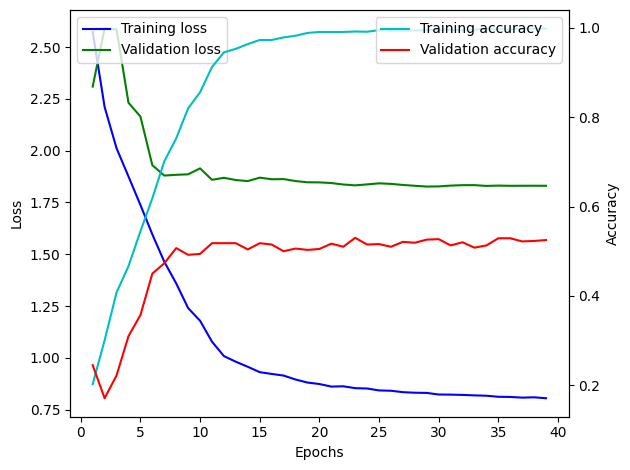

In [22]:
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

epochs = range(1, len(history_dict['acc']) + 1)

fig, ax1 = plt.subplots()
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.plot(epochs, loss_values, color='b', label='Training loss')
ax1.plot(epochs, val_loss_values, color='g', label='Validation loss')
ax1.tick_params(axis='y')
plt.legend(loc=2)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.set_ylabel('Accuracy')  # we already handled the x-label with ax1
ax2.plot(epochs, acc_values, color='c', label='Training accuracy')
ax2.plot(epochs, val_acc_values, color='r', label='Validation accuracy')
ax2.tick_params(axis='y')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.legend(loc=1)
plt.show()

### II.5. Entraînement d'un CNN avec points d'arrêt et reprises (à passer en première lecture)

Pour des entraînements plus conséquents, il est primordial d'enregistrer les modèles intermédiaires afin de ne pas tout perdre si l'apprentissage venait à s'interrompre de façon impromptue. On peut enregistrer le modèle dans un fichier .hdf

Si vous regardez plus attentivement, lors de l'entrainement précédent nous avons crée un object **ModelCheckpoint**. Il permet d'enregistrer le meilleur modèle (au sens d'une metrique à préciser) dans un fichier nommé *my_model.h5*. Verifiez que ce fichier se trouve bien votre espace de travail.

L'argument ***period*** de l'objet ModelCheckpoint vous permet de definir la fréquence des enregistrements.

In [23]:
from keras.api.models import load_model

Une fois le modele obtenu, on peut l'enregister et le recharger comme ceci: load_model(filepath)

In [24]:
# from keras.api.models import load_model

# import pathlib
# file = pathlib.Path(filepath)
# if file.exists():
#     model = load_model(filepath)
# else:
#     model.set_weights(weights_init)
#     callbacks = [time_callback,checkpoint]
# history_2 = model.fit(x_train, y_train, batch_size=8, epochs=10, verbose=1, validation_data=(x_val, y_val),
#                       callbacks = callbacks)

# III - Test et Évaluation du modèle en prédiction

### III.1. Test du modèle sur les données de test

Testons la prédiction de notre modèle sur quelques images de test au hasard...

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


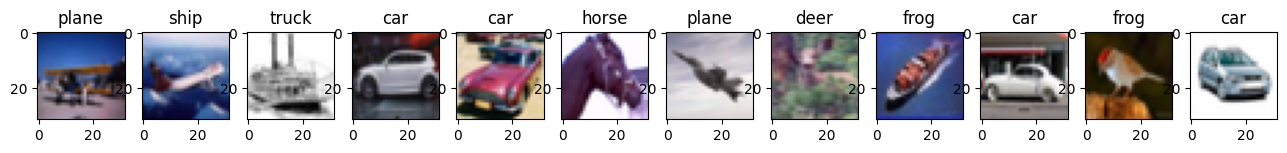

In [25]:
random_ids = np.random.choice(len(x_test), n_display, replace=False)
pred = np.argmax(model.predict(x_test[random_ids]), axis=1)
f, axarr = plt.subplots(1,n_display,figsize=(16,16))
for k in range(n_display):
    axarr[k].imshow(x_test_initial[random_ids[k]])
    axarr[k].title.set_text(classes[pred[k]])

Vos premiers résultats semblent-ils corrects ?

Hum ! Affichons à présent la précision sur l'ensemble de votre base :

In [26]:
print("Précision du réseau sur les {} images d'entraînement : {:.2f} %".format(n_training_samples, 100 * history_dict['acc'][-1]))
print("Précision du réseau sur les {} images de validation : {:.2f} %".format(n_valid, 100 * history_dict['val_acc'][-1]))

Précision du réseau sur les 5000 images d'entraînement : 99.83 %
Précision du réseau sur les 1000 images de validation : 52.50 %


In [27]:
def accuracy_per_class(model):
    n_classes = len(classes)
    confusion_matrix = np.zeros((n_classes, n_classes), dtype=np.int64)
    
    pred = np.argmax(model.predict(x_test), axis=1)
    for i in range(len(y_test)):
        confusion_matrix[np.argmax(y_test[i]), pred[i]] += 1
    
    print("{:<10} {:^10}".format("Classe", "Précision (%)"))
    total_correct = 0
    for i in range(n_classes):
        class_total = confusion_matrix[i, :].sum()
        class_correct = confusion_matrix[i, i]
        total_correct += class_correct
        percentage_correct = 100.0 * float(class_correct) / class_total
        print('{:<10} {:^10.2f}'.format(classes[i], percentage_correct))
    test_acc = 100.0 * float(total_correct) / len(y_test)
    print("Précision du réseau sur les {} images de test : {:.2f} %".format(len(y_test),test_acc))
    return confusion_matrix

confusion_matrix = accuracy_per_class(model)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Classe     Précision (%)
plane        54.76   
car          69.16   
bird         25.77   
cat          23.85   
deer         50.00   
dog          54.17   
frog         69.00   
horse        50.48   
ship         72.12   
truck        67.78   
Précision du réseau sur les 1000 images de test : 53.50 %


### III.2. Matrices de Confusion

Les matrices de confusion nous renseignent plus précisément sur la nature des erreurs commises par notre modèle.

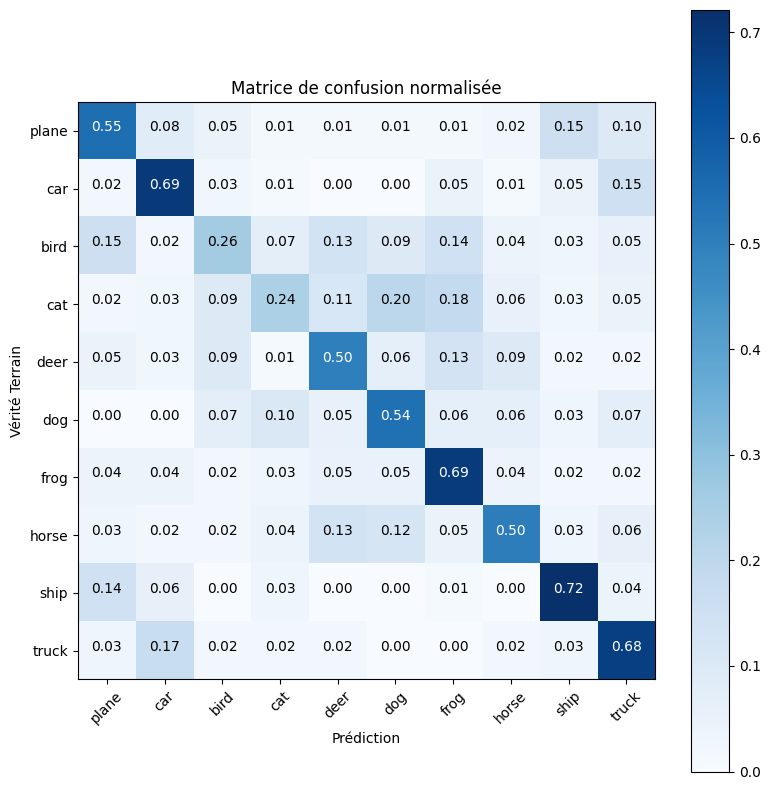

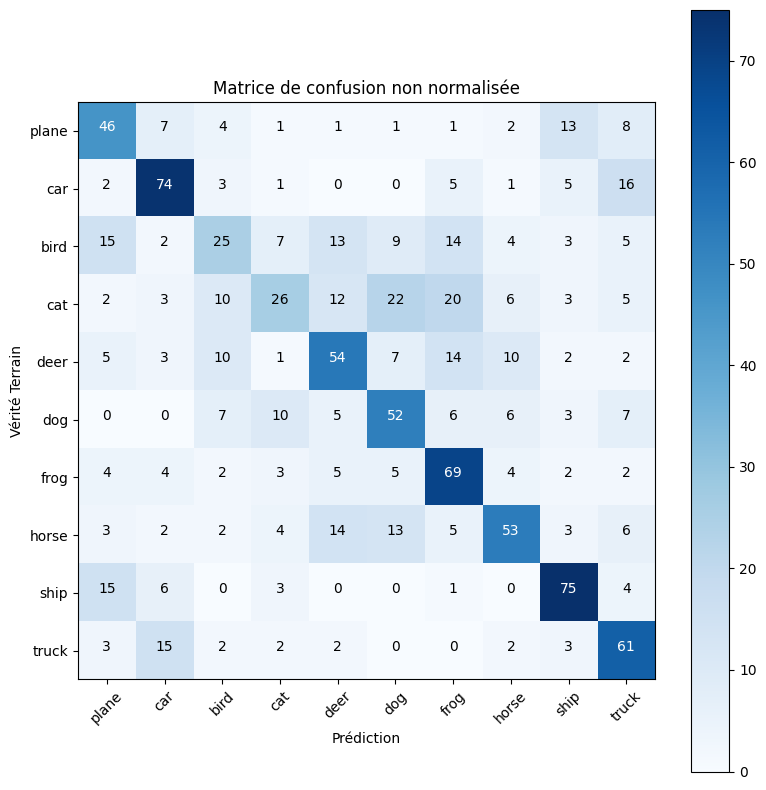

In [28]:
# Plot normalized confusion matrix
plot_confusion_matrix(confusion_matrix, classes, normalize=True,
                      title='Matrice de confusion normalisée')

# Plot non-normalized confusion matrix
plot_confusion_matrix(confusion_matrix, classes,
                      title='Matrice de confusion non normalisée')

# IV - Visualisation des zones d'activation

In [29]:
from keras.api.models import Model

first_conv = Model(inputs=model.inputs, outputs=model.layers[1].output)
first_conv.summary()

second_conv = Model(inputs=model.inputs, outputs=model.layers[3].output)
second_conv.summary()

first_block = Model(inputs=model.inputs, outputs=model.layers[5].output)
first_block.summary()

second_block = Model(inputs=model.inputs, outputs=model.layers[11].output)
second_block.summary()

Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,024 (4.00 KB)

 Trainable params: 960 (3.75 KB)

 Non-trainable params: 64 (256.00 B)

Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,400 (40.62 KB)

 Trainable params: 10,272 (40.12 KB)

 Non-trainable params: 128 (512.00 B)

Model: "functional_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16, 16, 32)     │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,400 (40.62 KB)

 Trainable params: 10,272 (40.12 KB)

 Non-trainable params: 128 (512.00 B)

Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,369,440 (16.67 MB)

 Trainable params: 4,369,312 (16.67 MB)

 Non-trainable params: 128 (512.00 B)

In [30]:
first_conv_feature_maps = first_conv.predict(x_test)
second_conv_feature_maps = second_conv.predict(x_test)
first_block_feature_maps = first_block.predict(x_test)
second_block_feature_maps = second_block.predict(x_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

c:\Users\rianr\MI204\.venv\lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_37']
Received: inputs=Tensor(shape=torch.Size([32, 32, 32, 3]))
  warnings.warn(msg)
c:\Users\rianr\MI204\.venv\lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_37']
Received: inputs=Tensor(shape=torch.Size([8, 32, 32, 3]))
  warnings.warn(msg)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


In [31]:
def get_mask(k, feature_maps):
    feature_maps_positive = np.maximum(feature_maps[k], 0)
    mask = np.sum(feature_maps_positive,axis=2)
    mask = mask / np.max(mask)
    return mask

Test images
First CONV2D
Second CONV2D
MAXPOLL - End of First Block
MAXPOLL - End of Second Block


AxisError: axis 2 is out of bounds for array of dimension 1

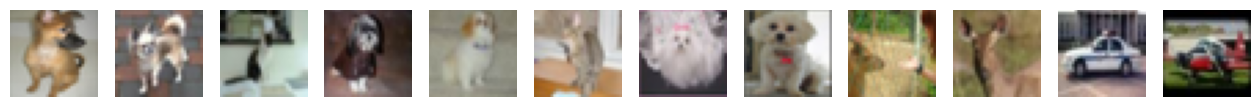

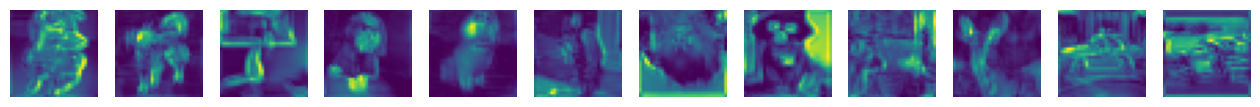

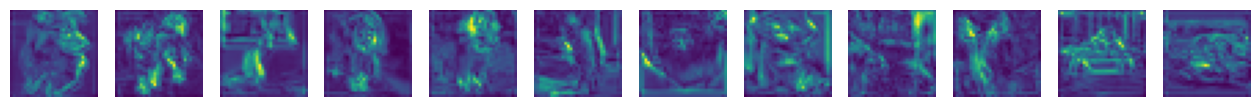

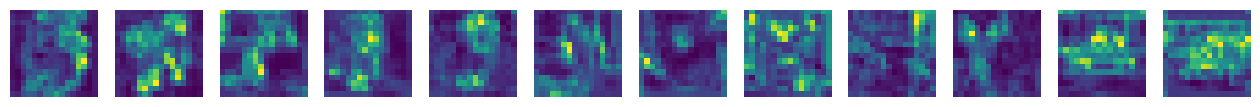

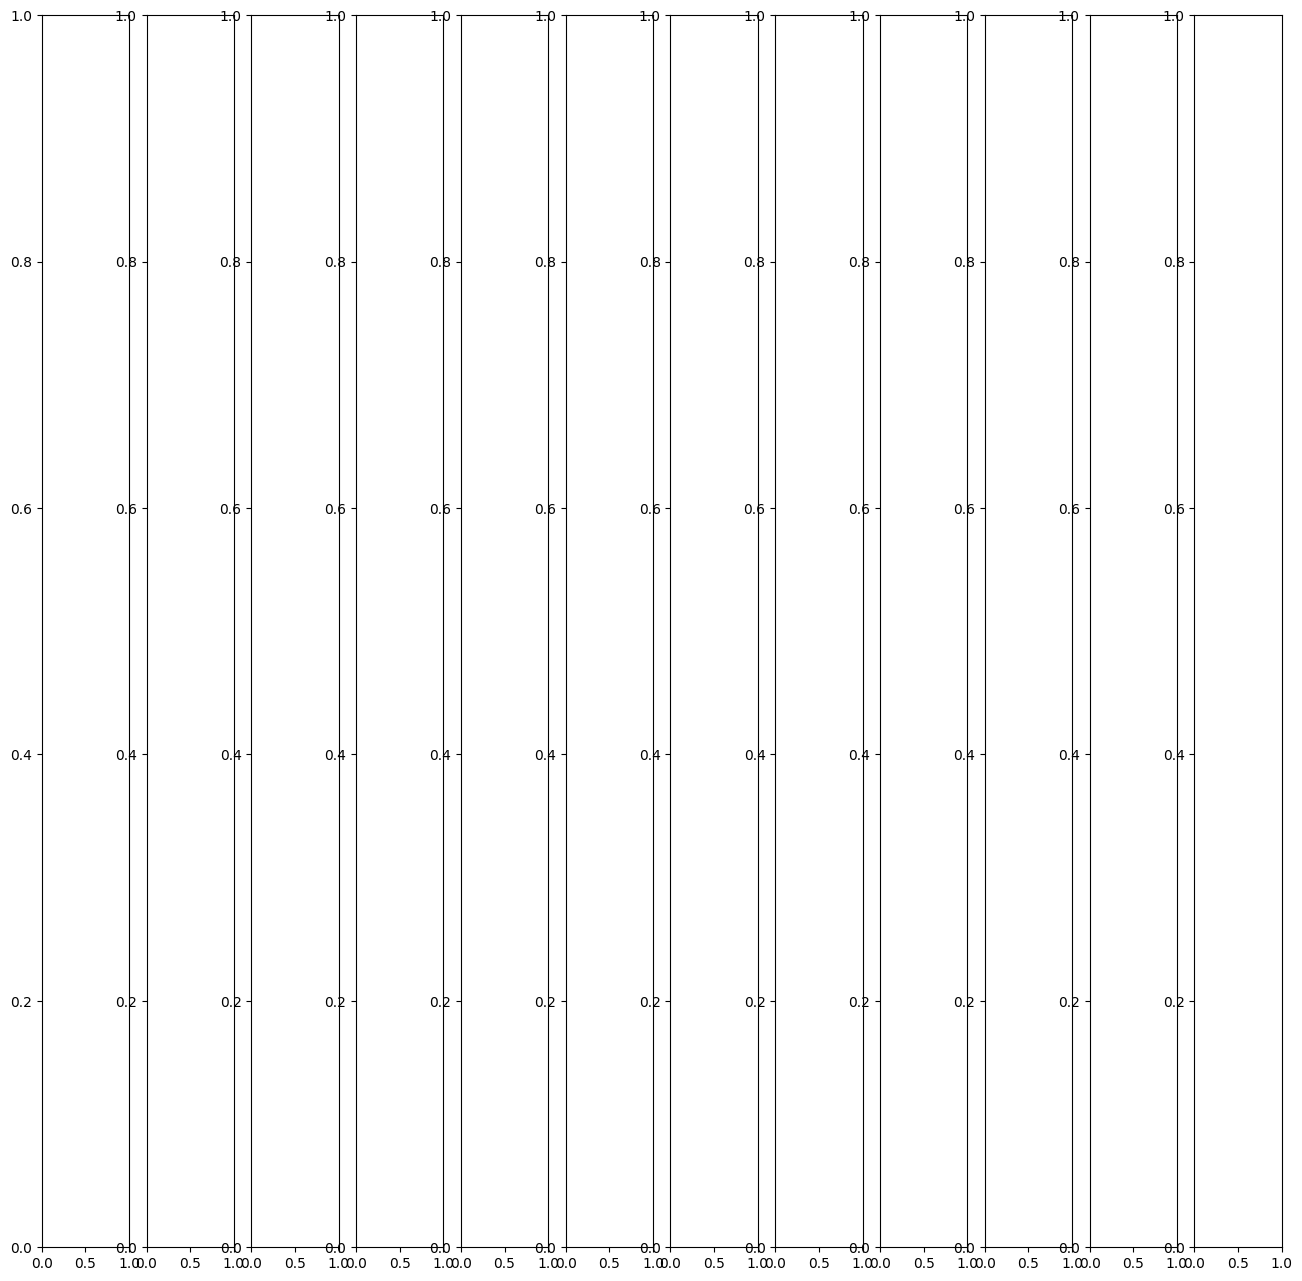

In [32]:
random_ids = np.random.choice(len(x_test), n_display, replace=False)

print("Test images")
f, rd_img = plt.subplots(1,n_display,figsize=(16,16))
for k in range(n_display):
    img = x_test_initial[random_ids[k]]
    rd_img[k].imshow(img)
    rd_img[k].axis('off')

print("First CONV2D")
f, rd_maps = plt.subplots(1,n_display,figsize=(16,16))
for k in range(n_display):
    mask = get_mask(random_ids[k], first_conv_feature_maps)
    rd_maps[k].imshow(mask)
    rd_maps[k].axis('off')

print("Second CONV2D")
f, rd_maps = plt.subplots(1,n_display,figsize=(16,16))
for k in range(n_display):
    mask = get_mask(random_ids[k], second_conv_feature_maps)
    rd_maps[k].imshow(mask)
    rd_maps[k].axis('off')

print("MAXPOLL - End of First Block")
f, rd_maps = plt.subplots(1,n_display,figsize=(16,16))
for k in range(n_display):
    mask = get_mask(random_ids[k], first_block_feature_maps)
    rd_maps[k].imshow(mask)
    rd_maps[k].axis('off')

print("MAXPOLL - End of Second Block")
f, rd_maps = plt.subplots(1,n_display,figsize=(16,16))
for k in range(n_display):
    mask = get_mask(random_ids[k], second_block_feature_maps)
    rd_maps[k].imshow(mask)
    rd_maps[k].axis('off')